In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tsfel as ts

**Main preprocessing turning extra vars and raw dataframe into dataframe to be put into TFT**

In [2]:
extra_vars = pd.read_csv('../data/extra_data.csv')

C:\Users\Joseph.Amess\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (10,11,13,15,16,20,26,30,33,34) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
print(extra_vars.columns.values)
print(extra_vars.shape)

['CalendarPeriod' 'ItemID' 'PlantID' 'SalesTargetGroupID' 'Period'
 'PlanningPeriod' 'PlannedPeriod' 'PeriodDiff' 'ProductLineID' 'Plant'
 'SalesTargetGroup' 'ItemGroupFlag' 'PlantFlag' 'SalesTargetGroupFlag'
 'UpdateMode' 'Country' 'DistributionChannel' 'ItemGroupID' 'ItemGroup'
 'Division' 'ABCIndicator' 'SKULabel' 'CountryID' 'NewProductIndicator'
 'Quality' 'RimSize' 'SAG1' 'SAG2' 'SAG3' 'SAG4' 'Season' 'SpeedIndex'
 'SKU' 'UHPNonUHPIndicator' 'SalesOffice' 'PlanningVersion'
 'ProportionalFactor' 'FixedProportionalFactor' 'AbsoluteGrossMargin'
 'BaseUnit' 'BaselineForecast' 'SalesBudget' 'ClusterHeadCorrection'
 'CorrectedSalesHistory' 'EuroPoolGrowthPercentage' 'EuroPoolGrowth'
 'ExtraKF01' 'ExtraKF02' 'ExtraKF03' 'ExtraKF04' 'ExtraKF05' 'ExtraKF06'
 'ExtraKF07' 'ExtraKF08' 'ExtraKF09' 'ExtraKF10' 'FinalBaseForecast'
 'FinalRollingForecast' 'ForecastSnapShot' 'OrderWallet' 'SalesHistory'
 'SalesCorrections' 'SellingPrice' 'SalesHeadCorrection' 'SalesYearMinus1'
 'SalesYearMinus2' 

In [3]:
#raw data file
data = pd.read_csv('../data/data__raw_23_03_22.csv')

C:\Users\Joseph.Amess\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
#merge extra selected vars with raw data file
def merge_dataframes(data, extra_data, selected_cols):
    data = data.reset_index()
    extra_data = extra_data.reset_index()
    extra_data_grouped = extra_data.groupby(['PlantID', 'ParentItemID'], as_index=False).first()
    extra_data_grouped = extra_data_grouped[selected_cols]
    data_updated = pd.merge(data, extra_data_grouped, how='left', on=['ParentItemID', 'PlantID'])
    return data_updated


COLS = ['PlantID', 'ParentItemID', 'SAG1', 'SAG2', 'SAG3', 'SAG4', 
        'Quality', 'RimSize', 'Season', 'SpeedIndex', 'UHPNonUHPIndicator', 
        'SalesTargetGroup', 'Division']

data_updated = merge_dataframes(data, extra_vars, COLS)

In [6]:
print(data_updated.shape)
print(data.shape)
print(data_updated.head())

(2906736, 22)
(2906736, 10)
   index ProductLineID PlanningPeriod       ParentItemID PlantID  \
0      0           PCR     2022-01-01  AI15570013TARCA20    5M01   
1      1           PCR     2022-01-01  AI15570013TARCA20    5M01   
2      2           PCR     2022-01-01  AI15570013TARCA20    5M01   
3      3           PCR     2022-01-01  AI15570013TARCA20    5M01   
4      4           PCR     2022-01-01  AI15570013TARCA20    5M01   

  PlannedPeriod  PeriodDiff FieldID  FieldContent UpdateBy  ... SAG2 SAG3  \
0    2019-02-01         -35  ACTSLS            15     Proc  ...  WSP  WIN   
1    2019-03-01         -34  ACTSLS             0     Proc  ...  WSP  WIN   
2    2019-04-01         -33  ACTSLS             0     Proc  ...  WSP  WIN   
3    2019-05-01         -32  ACTSLS             0     Proc  ...  WSP  WIN   
4    2019-06-01         -31  ACTSLS             8     Proc  ...  WSP  WIN   

  SAG4 Quality RimSize           Season  SpeedIndex UHPNonUHPIndicator  \
0   AB       A    13.0  WI

In [7]:
#drop nulls
def drop_nulls(data):
    data = data[data['ForecastFlag'] == 1]
    return data


#Keep only actual sales select planning period and remove uneeded cols
def drop_cols_and_rows(data, cols_to_drop, row_to_keep, period_choice):
    data = data[data['FieldID'].isin(row_to_keep)]
    data = data[data['PlanningPeriod'] == period_choice]
    data.drop(columns=cols_to_drop, axis=1, inplace=True)
    return data


#Rename cols
def col_renamer(data, rename_dict):
    for col_name in list(rename_dict.keys()):
        data.rename(columns={col_name:rename_dict[col_name]}, inplace=True)
    return data


#Select cols to keep
def col_selecter(data, selected_cols):
    data = data[selected_cols]
    return data


#Make artificial time index to pass into dataframe builer
def create_time_index(data):
    data['Date']= pd.to_datetime(data['Date'])
    data["Date"].dt.year * 12
    data["time_idx"] = data["Date"].dt.year * 12 + data["Date"].dt.month
    data["time_idx"] -= data["time_idx"].min()
    data["month"] = data.Date.dt.month.astype(str).astype("category")
    return data


#Only use if want to remove final time index
def remove_last_time_idx(data):
    data = data[data['time_idx'] != 35]
    return data


#Create average cols for groups, remove volume under zero
def feature_engineering(data):
    data.Volume=data.Volume.mask(data.Volume.lt(0),0)
    data["log_volume"] = np.log(data.Volume + 1e-8)
    data['log_ret'] = data['log_volume'] - data['log_volume'].shift(1)
    data['log_ret'] = data['log_ret'].fillna(0)
    data["avg_volume_by_material"] = data.groupby(["time_idx", "ParentItemID"], observed=True).Volume.transform("mean") #removed plantID
    data["max_volume_by_material"] = data.groupby(["time_idx", "ParentItemID"], observed=True).Volume.transform("max")
    data["min_volume_by_material"] = data.groupby(["time_idx", "ParentItemID"], observed=True).Volume.transform("min")
    data["std_volume_by_material"] = data.groupby(["time_idx", "ParentItemID"], observed=True).Volume.transform("std")
    data["std_volume_by_material"] = data.groupby(["time_idx", "ParentItemID"], observed=True).Volume.transform("sum")
    data["avg_volume_by_plant"] = data.groupby(["time_idx", "PlantID"], observed=True).Volume.transform("mean")
    data["max_volume_by_plant"] = data.groupby(["time_idx", "PlantID"], observed=True).Volume.transform("max")
    data["min_volume_by_plant"] = data.groupby(["time_idx", "PlantID"], observed=True).Volume.transform("min")
    data["std_volume_by_plant"] = data.groupby(["time_idx", "PlantID"], observed=True).Volume.transform("std")
    data["std_volume_by_plant"] = data.groupby(["time_idx", "PlantID"], observed=True).Volume.transform("sum")
    data = data.assign(
                        timeseries=pd.factorize(list(zip(
                        *[data[c].values.tolist() for c in ['ParentItemID', 'PlantID']] #removed plantID
                        )))[0] + 1
                        )
    return data


#Print summary of data
def data_summary(data):
    print('')
    print('Data size:')
    print(data.shape)
    print('Data columns:')
    print(data.columns.values)
    print('')

#For filtering out timeseries where there is no APO forecast
def forecast_filtering(data):
    timeseries_selection = list(data.groupby('timeseries').filter(lambda x: sum(x['Volume']) > 1)['timeseries'].unique())
    forecast_data = data[data['timeseries'].isin(timeseries_selection)]
    return timeseries_selection, forecast_data


#Based on timeseries from forecast filtering, filter timeseries of actual sales 
def sales_filtering(data, timeseries_selection):
    filtered_data = data[data['timeseries'].isin(timeseries_selection)]
    return filtered_data

In [8]:
#Filter forecasts where there is a prediction
def preprocessing(data, cols_to_drop, row_to_keep, rename_dict, selected_cols, period_choice):
    data_summary(data)
    #data = drop_nulls(data)
    data = drop_cols_and_rows(data, cols_to_drop, row_to_keep, period_choice)
    data = col_renamer(data, rename_dict)
    data = col_selecter(data, selected_cols)
    data = create_time_index(data)
    data = remove_last_time_idx(data)
    data = feature_engineering(data)
    timeseries_selection, forecast_data = forecast_filtering(data)
    data_summary(forecast_data)
    return timeseries_selection, forecast_data


COLS_TO_DROP = ['FieldID', 'UpdateBy', 'UpdateWhen', 'PlanningPeriod', 'ProductLineID', 'PeriodDiff']
ROW_TO_KEEP = ['SLSHDCRC']
RENAME_DICT = {'FieldContent':'Volume', 'PlannedPeriod':'Date'}
SELECTED_COLS = ['ParentItemID', 'PlantID', 'Volume', 'Date', 
                'SAG1', 'SAG2', 'SAG3', 'SAG4', 'Quality', 
                'RimSize', 'Season', 'SpeedIndex', 'UHPNonUHPIndicator']
PLANNING_DATE = '2022-01-01'
timeseries_selection, forecast_data = preprocessing(data_updated, COLS_TO_DROP, ROW_TO_KEEP, RENAME_DICT, SELECTED_COLS, PLANNING_DATE)


Data size:
(2906736, 22)
Data columns:
['index' 'ProductLineID' 'PlanningPeriod' 'ParentItemID' 'PlantID'
 'PlannedPeriod' 'PeriodDiff' 'FieldID' 'FieldContent' 'UpdateBy'
 'UpdateWhen' 'SAG1' 'SAG2' 'SAG3' 'SAG4' 'Quality' 'RimSize' 'Season'
 'SpeedIndex' 'UHPNonUHPIndicator' 'SalesTargetGroup' 'Division']


Data size:
(125412, 26)
Data columns:
['ParentItemID' 'PlantID' 'Volume' 'Date' 'SAG1' 'SAG2' 'SAG3' 'SAG4'
 'Quality' 'RimSize' 'Season' 'SpeedIndex' 'UHPNonUHPIndicator' 'time_idx'
 'month' 'log_volume' 'log_ret' 'avg_volume_by_material'
 'max_volume_by_material' 'min_volume_by_material'
 'std_volume_by_material' 'avg_volume_by_plant' 'max_volume_by_plant'
 'min_volume_by_plant' 'std_volume_by_plant' 'timeseries']



In [9]:
print(forecast_data.shape[0] / 12)

10451.0


In [10]:
#Filter true volume wrt to filtered forecasts
def preprocessing_2(data, cols_to_drop, row_to_keep, rename_dict, selected_cols, period_choice, timeseries_selection):
    data_summary(data)
    #data = drop_nulls(data)
    data = drop_cols_and_rows(data, cols_to_drop, row_to_keep, period_choice)
    data = col_renamer(data, rename_dict)
    data = col_selecter(data, selected_cols)
    data = create_time_index(data)
    data = remove_last_time_idx(data)
    data = feature_engineering(data)
    filtered_data = sales_filtering(data, timeseries_selection)
    data_summary(filtered_data)
    return filtered_data


COLS_TO_DROP = ['FieldID', 'UpdateBy', 'UpdateWhen', 'PlanningPeriod', 'ProductLineID', 'PeriodDiff']
ROW_TO_KEEP = ['ACTSLS']
RENAME_DICT = {'FieldContent':'Volume', 'PlannedPeriod':'Date'}
SELECTED_COLS = ['ParentItemID', 'PlantID', 'Volume', 'Date', 
                'SAG1', 'SAG2', 'SAG3', 'SAG4', 'Quality', 
                'RimSize', 'Season', 'SpeedIndex', 'UHPNonUHPIndicator']
PLANNING_DATE = '2022-01-01'
filtered_data = preprocessing_2(data_updated, COLS_TO_DROP, ROW_TO_KEEP, RENAME_DICT, SELECTED_COLS, PLANNING_DATE, timeseries_selection)


Data size:
(2906736, 22)
Data columns:
['index' 'ProductLineID' 'PlanningPeriod' 'ParentItemID' 'PlantID'
 'PlannedPeriod' 'PeriodDiff' 'FieldID' 'FieldContent' 'UpdateBy'
 'UpdateWhen' 'SAG1' 'SAG2' 'SAG3' 'SAG4' 'Quality' 'RimSize' 'Season'
 'SpeedIndex' 'UHPNonUHPIndicator' 'SalesTargetGroup' 'Division']


Data size:
(365785, 26)
Data columns:
['ParentItemID' 'PlantID' 'Volume' 'Date' 'SAG1' 'SAG2' 'SAG3' 'SAG4'
 'Quality' 'RimSize' 'Season' 'SpeedIndex' 'UHPNonUHPIndicator' 'time_idx'
 'month' 'log_volume' 'log_ret' 'avg_volume_by_material'
 'max_volume_by_material' 'min_volume_by_material'
 'std_volume_by_material' 'avg_volume_by_plant' 'max_volume_by_plant'
 'min_volume_by_plant' 'std_volume_by_plant' 'timeseries']



In [11]:
print('Number of timeseries remaining:', filtered_data.shape[0] / 35)

Number of timeseries remaining: 10451.0


In [12]:
print(filtered_data.shape)

(365785, 26)


In [13]:
print(filtered_data['time_idx'].unique())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]


In [14]:
#Check filtering has worked
def check_volume(data, selected_timeseries):
    count = 0
    for series in selected_timeseries:
        timeseries_vol_sum = sum(data[data['timeseries'] == series]['Volume'])
        if timeseries_vol_sum < 2:
            count += 1
    print(count)

check_volume(forecast_data, timeseries_selection)

0


In [15]:
#Add in encodings from autoencoder
encodings = np.load('../data/temporal_encodings.npy')
#temporal_features = pd.read_csv('../data/temporal_feature_set')

In [16]:
def add_encodings(data, encodings):
    ts_list = list(data.timeseries.unique())
    encoding_array = np.zeros((data.shape[0], 3))
    for i in range(1, len(ts_list)):
        ts_encodings_array = np.zeros((35, 3))
        ts_encodings = encodings[i, :]
        encoding_1_array = np.full((35), ts_encodings[0])
        encoding_2_array = np.full((35), ts_encodings[1])
        encoding_3_array = np.full((35), ts_encodings[2])
        ts_encodings_array[:, 0] = encoding_1_array
        ts_encodings_array[:, 1] = encoding_2_array
        ts_encodings_array[:, 2] = encoding_3_array
        encoding_array[(i - 1) * 35:i * 35, :] = ts_encodings_array
    encoding_df = pd.DataFrame(encoding_array, columns=['encoding_1', 'encoding_2', 'encoding_3']).reset_index()
    data = data.reset_index()
    data_new = pd.concat([data, encoding_df], axis=1)
    return data_new


data_new = add_encodings(filtered_data, encodings)

In [17]:
def add_temporal_features(data, features):
    features = pd.concat([features] * 35, ignore_index=True)
    features = features.sort_values('Unnamed: 0', axis=0)
    data = data.reset_index()
    data_new = pd.concat([data, features], axis=1)
    return data_new


#data_new = add_temporal_features(filtered_data, temporal_features)

In [84]:
pd.DataFrame.to_csv(data_new, '../data/data_processed_plant_item_new_vars_15_03_22_V2.csv')

In [58]:
#filter zeros
def remove_zeros(data, zero_threshold):
    print('before filter:')
    print(data.shape)
    print('Num of timeseries:', len(data['timeseries'].unique()))
    selected_data = data.groupby('timeseries', as_index=False).filter(lambda x: sum(x['Volume'].iloc[29::].lt(5)) < zero_threshold)
    print('')
    print('After filter:')
    print(selected_data.shape)
    print('Num of timeseries:', len(selected_data['timeseries'].unique()))
    print('')
    print('Percent timeseries removed:', round(100 - (100 *  len(selected_data['timeseries'].unique()) / (len(data['timeseries'].unique()))), 2), '%')
    return selected_data


#ZERO_THRESHOLD = 4
#selected_data = remove_zeros(data_processed, ZERO_THRESHOLD)

In [19]:
def volume_distribution(data, percent_step, groupby_col):
    percent_range = list(range(0, 100, percent_step))
    timeseries_percentages = []
    timeseries_totals = []
    percent_steps = []
    cumulative_percent_steps = []
    cumulative_percents = []
    cumulative_percent = 0
    num_zeros_in_timeseries = data.groupby(groupby_col, as_index=False).agg(lambda x: 100 * (x.eq(0).sum() / 35))['Volume']
    print('')
    print('Completed groupby aggregation')
    print('')
    for percent in percent_range:
        #Crop from lower bound
        timeseries_upper = num_zeros_in_timeseries[num_zeros_in_timeseries >= percent]
        # This is to make sure that all 100% values are accounted for, they wouldnt be if I used < 100 for the final band
        if percent == percent_range[-1]:
            timeseries_lower = timeseries_upper
        else:
            #Crop from upper band
            timeseries_lower = timeseries_upper[timeseries_upper < percent + percent_step]
        #Calc percent of timeseries that fall into band
        timeseries_percentage = 100 * (timeseries_lower.shape[0] / num_zeros_in_timeseries.shape[0])
        #Cum percent
        cumulative_percent += timeseries_percentage
        cumulative_percents.append(cumulative_percent)
        timeseries_percentages.append(timeseries_percentage)
        #Counts without percent calc
        timeseries_totals.append(timeseries_lower.shape[0])
        #Create x axis labels
        range_of_pct = str(percent) + '' + '-' + '' + str(percent + percent_step) + '' + '%'
        cum_pct = '<=' + '' + str(percent + percent_step)
        cumulative_percent_steps.append(cum_pct)
        percent_steps.append(range_of_pct)
    #Check to see if adds to 100%
    print('Sum of percent timeseries:', sum(timeseries_percentages))
    return timeseries_percentages, timeseries_totals, cumulative_percents, cumulative_percent_steps, percent_steps

In [21]:
#Assess distribution of volume of filtered dataset
PERCENT_STEP = 5
GROUPBY = 'timeseries'
timeseries_percentages, timeseries_totals, cumulative_percents, cumulative_percent_steps, percent_steps = volume_distribution(
                                                                                                                                filtered_data, 
                                                                                                                                PERCENT_STEP,
                                                                                                                                GROUPBY)


Completed groupby aggregation

Sum of percent timeseries: 100.0


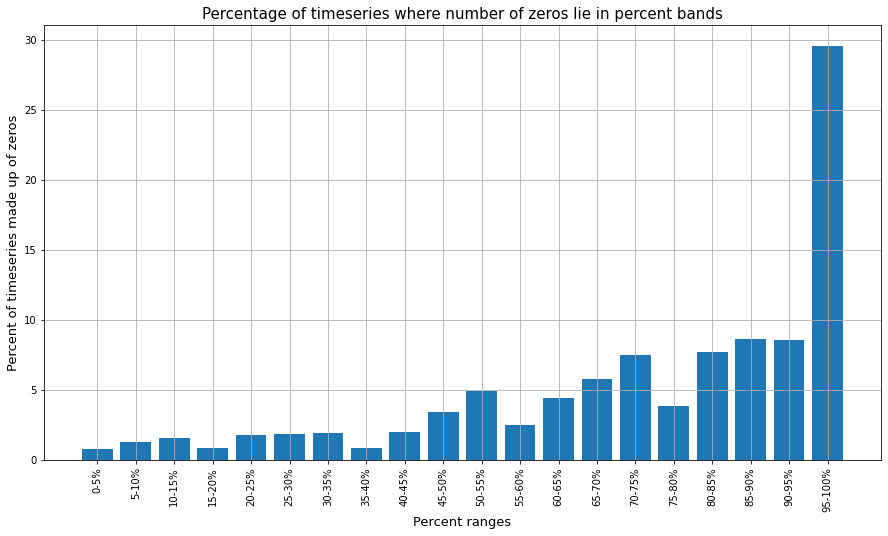

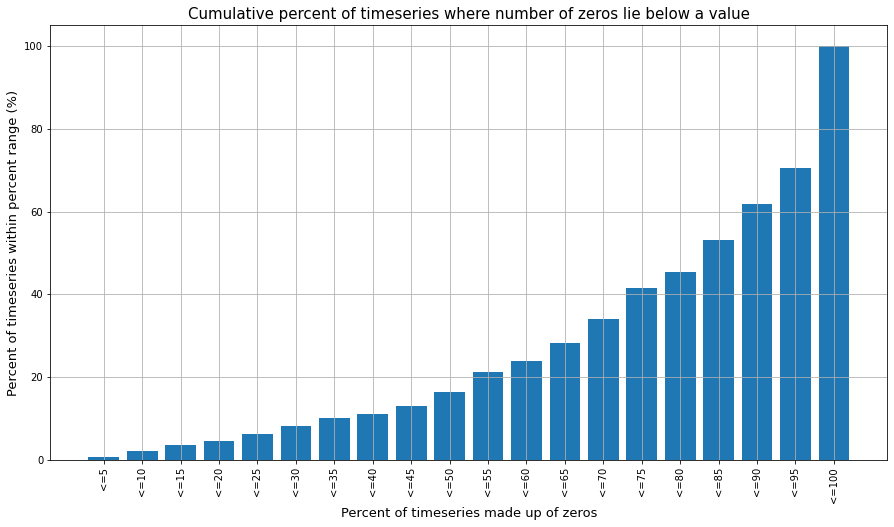

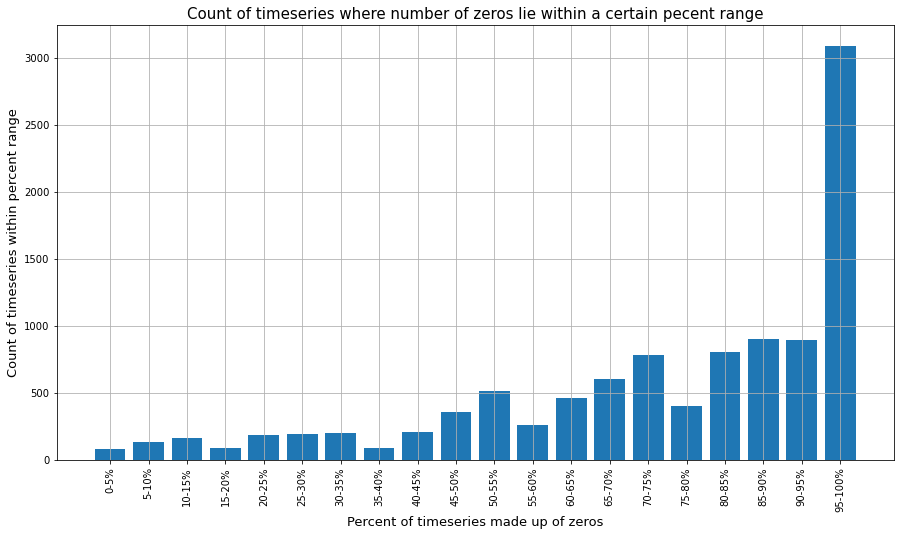

Old dataset


In [22]:
#Look at distribution of zeros in filtered dataframe

plt.figure(figsize=(15, 8))
plt.grid()
plt.title('Percentage of timeseries where number of zeros lie in percent bands', fontsize=15)
plt.bar(percent_steps, timeseries_percentages)
plt.xticks(rotation='vertical')
plt.xlabel('Percent ranges', fontsize=13)
plt.ylabel('Percent of timeseries made up of zeros', fontsize=13)
plt.show()

plt.figure(figsize=(15, 8))
plt.grid()
plt.title('Cumulative percent of timeseries where number of zeros lie below a value', fontsize=15)
plt.bar(cumulative_percent_steps, cumulative_percents)
plt.xticks(rotation='vertical')
plt.xlabel('Percent of timeseries made up of zeros', fontsize=13)
plt.ylabel('Percent of timeseries within percent range (%)', fontsize=13)
plt.show()

plt.figure(figsize=(15, 8))
plt.grid()
plt.title('Count of timeseries where number of zeros lie within a certain pecent range', fontsize=15)
plt.bar(percent_steps, timeseries_totals)
plt.xticks(rotation='vertical')
plt.xlabel('Percent of timeseries made up of zeros', fontsize=13)
plt.ylabel('Count of timeseries within percent range', fontsize=13)
plt.show()

print('Old dataset')

In [23]:
#pd.DataFrame.to_csv(filtered_data, '../data/data_processed_plant_item_12_03_22.csv')

In [24]:
#Remove timeseries predicted as zeros
#classifications = np.load('forecast_classification.npy')

In [25]:
def remove_zero_preds(classifications, data):
    print('num zeros in classifications:', len(classifications[classifications == 0]))
    timeseries_list = list(data.timeseries.unique())
    for i in range(len(timeseries_list)):
        ts_num = timeseries_list[i]
        if classifications[i] == 0:
            data = data[data['timeseries'] != ts_num]
    print('num timeseries left after removal:', len(data.timeseries.unique()))
    return data


#filtered_data_2 = remove_zero_preds(classifications, filtered_data)